# Apple Leaf and Fruit Diseases Classification Using Xception

Dataset credits: https://github.com/hsaleem1/NZDLPlantDisease-v1

Mount Google Drive

In [1]:
#Mount google drive to google colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
data_path ="/content/drive/MyDrive/Classroom/NewNZdataset"

Xception transfer learning is among the best two models. External_test dataset is used in prediction after evaluating the model with test dataset.

In [46]:
external_testing = "/content/drive/MyDrive/Classroom/External testing Dataset"

### Import all the Dependencies

In [47]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model


### Set all the Constants

In [48]:
BATCH_SIZE = 64
IMAGE_SIZE = 299  #---“input shape has to be `(299, 299 , 3)” → Xception
CHANNELS=3
epochs=100
classes =7

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [49]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15706 files belonging to 7 classes.


Loading External testing dataset to Test the best model

In [51]:
external_test = tf.keras.preprocessing.image_dataset_from_directory(
    external_testing,
    seed=41,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 726 files belonging to 7 classes.


In [52]:
#Print class names
class_names = dataset.class_names

class_names

['Black rot',
 'Black spot',
 'European Canker',
 'Healthy Fruit',
 'Healthy Leaf',
 'Leaf spot (scab)',
 'Mosaic virus ']

EXPLORATORY DATA ANALYSIS (EDA)

In [53]:
#Total number of images ≈ Number of batches × Batch size
len(dataset)

246

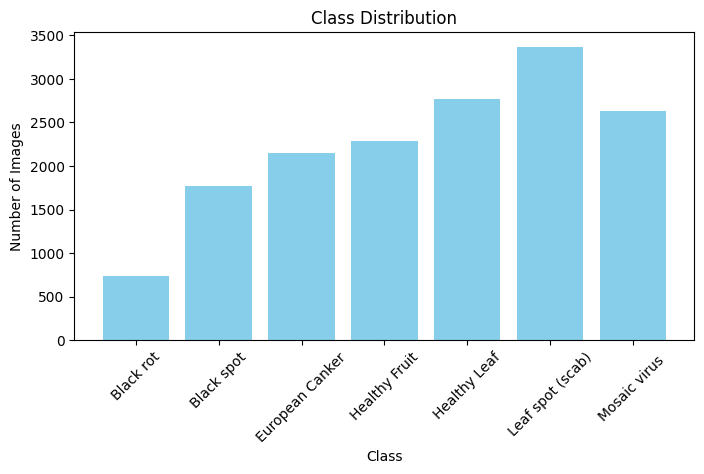

In [54]:
# Calculate the number of images per class
class_counts = dict.fromkeys(class_names, 0)

for images, labels in dataset:
    for label in labels:
        label = int(label.numpy())  # Convert to int if necessary
        class_counts[class_names[label]] += 1

# Plotting the class distribution
plt.figure(figsize=(8, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

Count the Element in Each Class

In [55]:
import tensorflow as tf
from collections import defaultdict

class_counts = defaultdict(int)

# Iterate through the dataset to count occurrences of each class
for batch in dataset:
    # Extract labels from the batch
    labels = batch[1]

    # Count occurrences of each label in this batch
    for label in labels:
        class_counts[label.numpy()] += 1

# Display the counts for each class with class names
print("Class counts:")
for class_index, count in class_counts.items():
    class_name = class_names[class_index]
    print(f"{class_name}: {count} images")

Class counts:
Leaf spot (scab): 3368 images
European Canker: 2147 images
Healthy Leaf: 2765 images
Healthy Fruit: 2282 images
Mosaic virus : 2636 images
Black rot: 742 images
Black spot: 1766 images


# Defining Class Weights

There are many more observations of the Leaf spot class, and so this will have a larger impact on the overall value of the loss function than observations belonging to the other classes. the weight is going to be used for training the models

In [56]:
# Example class counts (use your actual counts)
class_counts = {
    "Healthy Leaf": 2765,
    "Healthy Fruit": 2282,
    "Black spot": 1766,
    "European Canker": 2147,
    "Mosaic virus": 2636,
    "Leaf spot (scab)": 3368,
    "Black rot": 742,
}

# Total number of samples and unique classes
total_samples = sum(class_counts.values())
num_classes = len(class_counts)

# Calculate class weights
class_weights = {}
for i, (class_name, count) in enumerate(class_counts.items()):
    weight = total_samples / (num_classes * count)
    class_weights[i] = weight

In [57]:
#Check the shape of the first batch
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [ ]:
for image_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[[ 41.         62.         45.       ]
   [ 33.157192   54.157192   37.157192 ]
   [ 50.85451    69.29264    52.933105 ]
   ...
   [ 96.07858   160.71906    81.43811  ]
   [ 98.43143   162.43143    84.43143  ]
   [100.        164.         86.       ]]

  [[ 36.294315   60.43144    39.510033 ]
   [ 39.523243   63.045273   42.123867 ]
   [ 42.182835   63.978416   43.697483 ]
   ...
   [ 97.36517   162.00565    82.7247   ]
   [ 98.87735   162.87735    84.87735  ]
   [ 99.21572   163.21571    85.21572  ]]

  [[ 34.35953    65.12375    36.078594 ]
   [ 42.643005   73.125244   44.080097 ]
   [ 39.668068   67.56121    39.976933 ]
   ...
   [100.74146   163.6908     86.33125  ]
   [102.56649   165.28555    89.20696  ]
   [101.561874  164.28093    88.20234  ]]

  ...

  [[131.0904    167.16898   112.09039  ]
   [146.36151   183.44473   131.56488  ]
   [119.32238   156.91217   111.62605  ]
   ...
   [153.17226   157.99266   123.30151  ]
   [132.30916   136.30916   103.30916  ]
   [137.1474    

As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 64 elements of class labels

### Visualize some of the images from our dataset

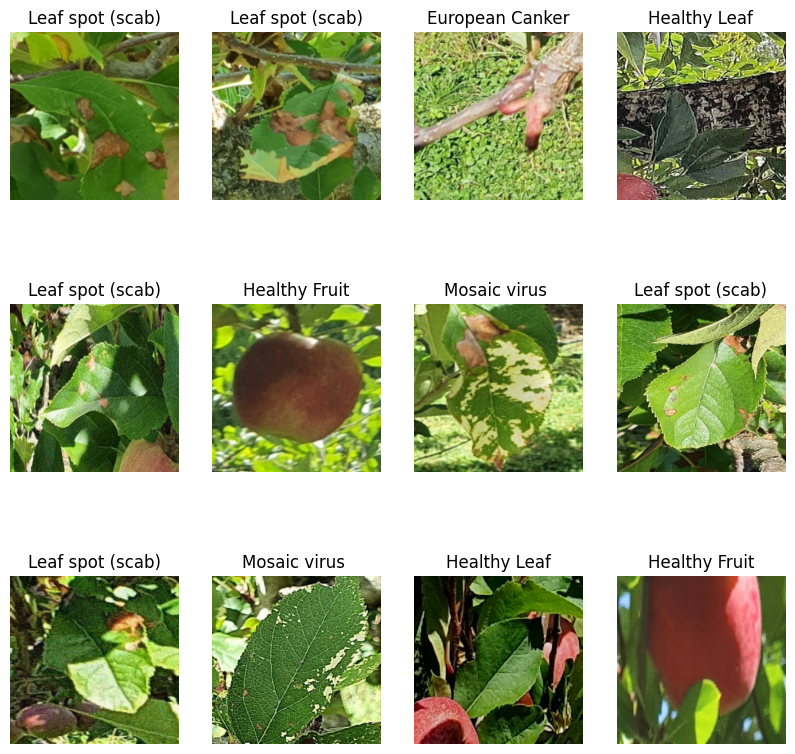

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [58]:

def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [59]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

172

In [ ]:
len(val_ds)

49

In [ ]:
len(test_ds)

25

### Cache, Shuffle, and Prefetch the Dataset

In [60]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
external_test = external_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Creating a Layer for Normalization
Before we feed our images to network,  to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 255).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.


In [61]:
rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255),])

## Building the Model

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, \
     Add, Dense, BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D

**Training From Scratch**

Conv-BatchNorm block

In [ ]:
def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

 SeparableConv-BatchNorm

In [ ]:
def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

Entry flow

In [ ]:
def entry_flow(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3)
    tensor = ReLU()(x)

    x = sep_bn(tensor, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=128, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=256, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=728, kernel_size=1, strides=2)
    x = Add()([tensor, x])

    return x

Middle Flow

In [ ]:
def middle_flow(tensor):
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)

        tensor = Add()([tensor, x])

    return tensor

Exit Flow

In [ ]:
def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=1024, kernel_size=3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=1024, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = sep_bn(x, filters=1536, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=2048, kernel_size=3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(units=classes, activation='softmax')(x)

    return x

The Model Code

In [ ]:
input = Input(shape=[299, 299, 3])
input=rescale(input)

x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

from tensorflow.keras import Model
model = Model(input, output)


# Defining Callbacks

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

In [ ]:
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),  # Factor to reduce learning rate
    patience=5,
    verbose=1
)

# Callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs to wait before stopping
    verbose=1,
    restore_best_weights=True
)

Defining the Optimizer

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=epochs,
    class_weight = class_weights,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
172/172 - 231s - loss: 1.0182 - accuracy: 0.5977 - val_loss: 1.8587 - val_accuracy: 0.2181 - lr: 0.0010 - 231s/epoch - 1s/step
Epoch 2/100
172/172 - 145s - loss: 0.4713 - accuracy: 0.8239 - val_loss: 2.6050 - val_accuracy: 0.1323 - lr: 0.0010 - 145s/epoch - 844ms/step
Epoch 3/100
172/172 - 146s - loss: 0.2910 - accuracy: 0.8987 - val_loss: 0.7418 - val_accuracy: 0.7073 - lr: 0.0010 - 146s/epoch - 850ms/step
Epoch 4/100
172/172 - 146s - loss: 0.2189 - accuracy: 0.9271 - val_loss: 1.4306 - val_accuracy: 0.7567 - lr: 0.0010 - 146s/epoch - 850ms/step
Epoch 5/100
172/172 - 146s - loss: 0.1457 - accuracy: 0.9550 - val_loss: 0.5762 - val_accuracy: 0.8575 - lr: 0.0010 - 146s/epoch - 850ms/step
Epoch 6/100
172/172 - 146s - loss: 0.1932 - accuracy: 0.9366 - val_loss: 2.7074 - val_accuracy: 0.6317 - lr: 0.0010 - 146s/epoch - 850ms/step
Epoch 7/100
172/172 - 146s - loss: 0.1090 - accuracy: 0.9670 - val_loss: 0.3836 - val_accuracy: 0.9043 - lr: 0.0010 - 146s/epoch - 851ms/step
Epoch 8/1

In [70]:
scores = model.evaluate(test_ds)

NameError: name 'model' is not defined

first image to predict
actual label: Healthy Leaf
2/2 [==============================] - 2s 18ms/step
predicted label: Healthy Leaf


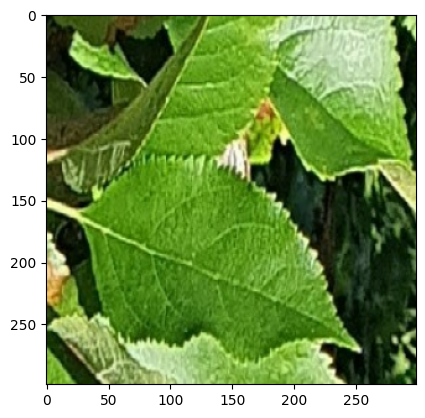

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Plotting training and validation accuracy, loss and learning rate

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

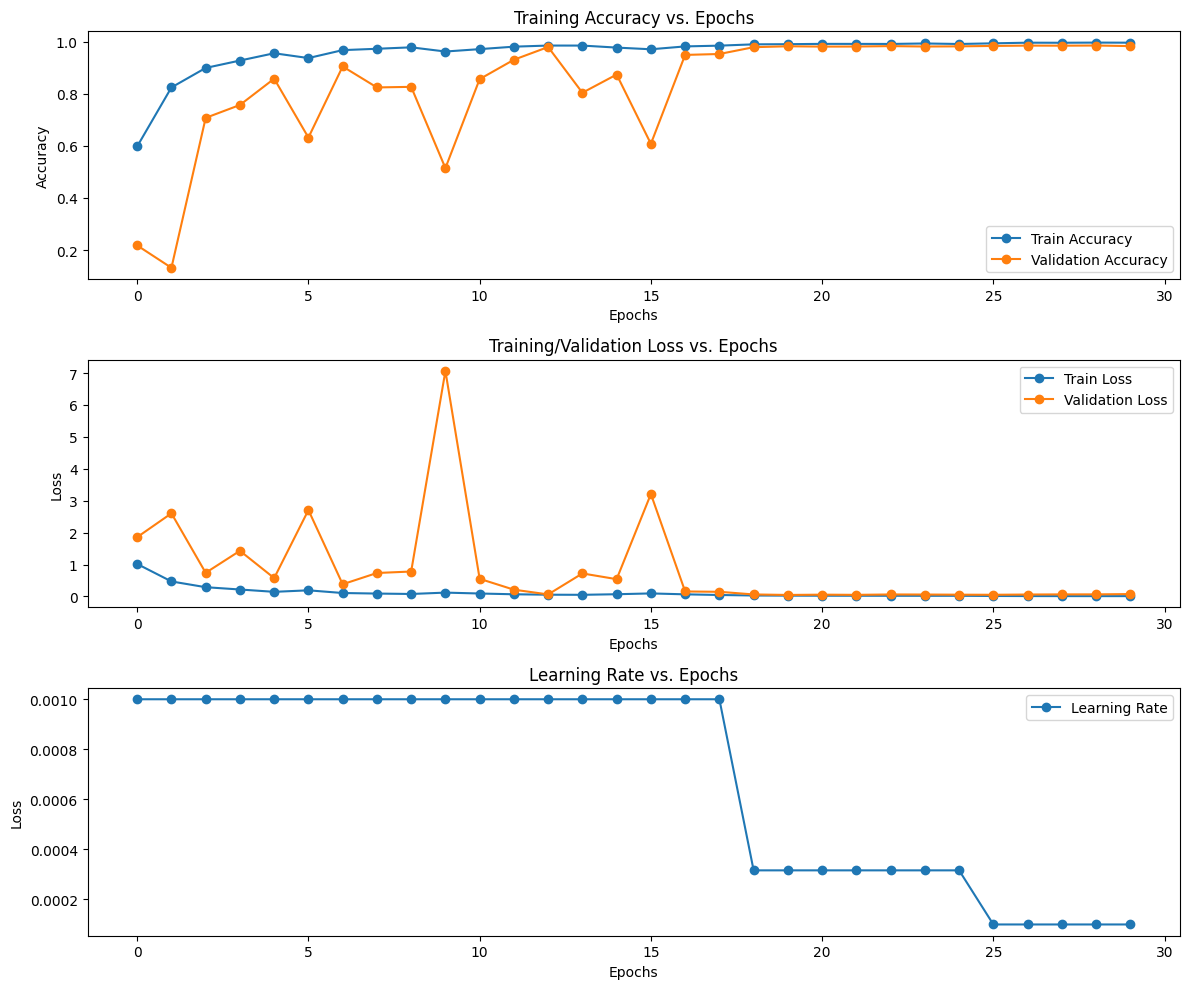

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

Confusion Matrix

2/2 [==============================] - 0s 117ms/step


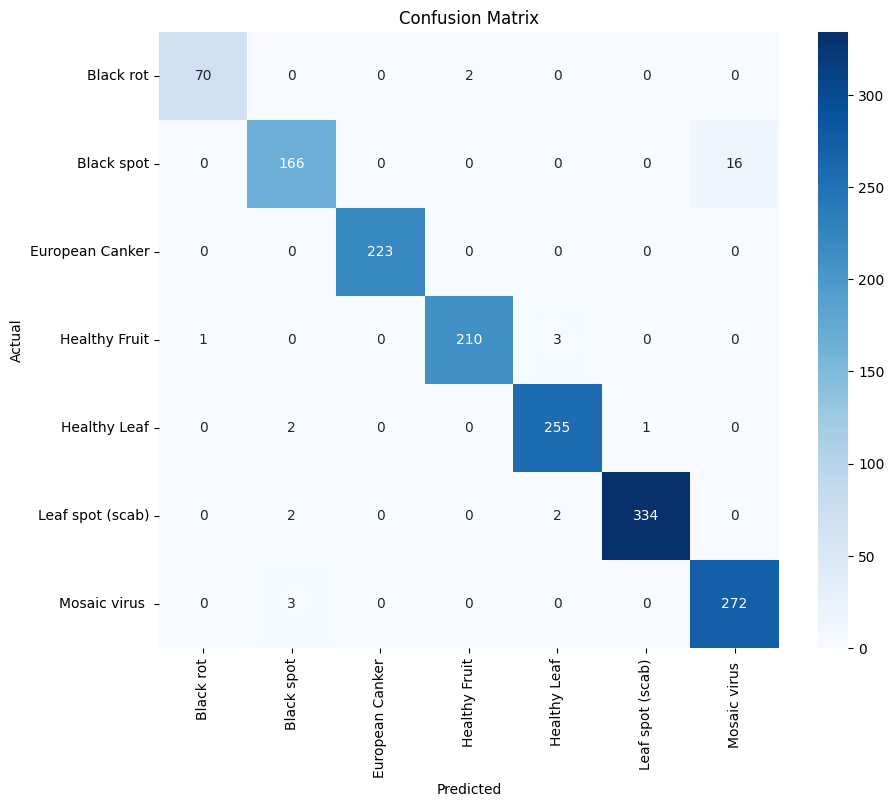

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model.predict(images)  # Get model predictions
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())  # Get predicted classes

# Confusion Matrix with class names
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Classificaiton Report with Precision, recall and f1 score

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names, zero_division=1)
print("Classification Report:\n", report)

Classification Report:
                   precision    recall  f1-score   support

       Black rot       0.99      0.97      0.98        72
      Black spot       0.96      0.91      0.94       182
 European Canker       1.00      1.00      1.00       223
   Healthy Fruit       0.99      0.98      0.99       214
    Healthy Leaf       0.98      0.99      0.98       258
Leaf spot (scab)       1.00      0.99      0.99       338
   Mosaic virus        0.94      0.99      0.97       275

        accuracy                           0.98      1562
       macro avg       0.98      0.98      0.98      1562
    weighted avg       0.98      0.98      0.98      1562



ROC - AUC

2/2 [==============================] - 0s 117ms/step


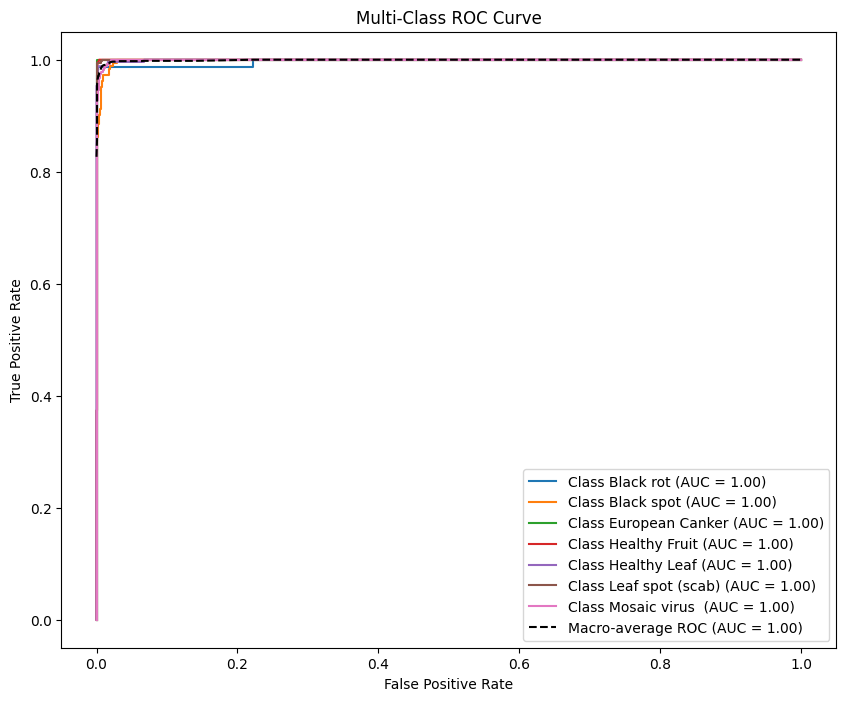

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model.predict(images)  # Get model predictions (probabilities)
    y_pred_probs.extend(predictions)  # Collect predicted probabilities

# Convert to NumPy arrays
y_true = np.array(y_true)  # Ensure true labels are arrays
y_pred_probs = np.array(y_pred_probs)  # Ensure predicted probabilities are arrays

# Binarize the true labels to get a one-hot encoded representation
y_true_bin = label_binarize(y_true, classes=list(range(20)))

# Initialize ROC and AUC data
fpr = dict()  # False positive rates
tpr = dict()  # True positive rates
roc_auc = dict()  # AUC for each class

# Compute ROC and AUC for each class
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])  # ROC data for each class
    roc_auc[i] = auc(fpr[i], tpr[i])  # AUC for each class

# Compute macro-average AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))
mean_tpr = np.zeros_like(all_fpr)

# Compute mean true positive rates
for i in range(classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= classes  # Normalize by the number of classes
macro_auc = auc(all_fpr, mean_tpr)  # Macro-average AUC

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')  # Label with class names and AUC

# Plot the macro-average ROC curve
plt.plot(all_fpr, mean_tpr, color='k', linestyle='--', label=f'Macro-average ROC (AUC = {macro_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Transfer Learning**

In [62]:

from keras.layers import Input

# this could also be the output a different Keras model or layer
input= Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
input = rescale(input)


In [63]:
# Load the xception pre-trained model without the top layer (fully connected layers)
xception = Xception(input_tensor=input, weights='imagenet', include_top=False)

In [64]:
# Freeze the layers of xception
for layer in xception.layers:
  layer.trainable =False

In [65]:
x = GlobalAveragePooling2D()(xception.output)
prediction = Dense(classes, activation ='softmax')(x)
#create a model object
model_tl =Model(inputs =xception.input, outputs =prediction)
#View the structure of the model
model_tl.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 299, 299, 3)          0         ['input_2[0][0]']             
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['sequential_1[0][0]']        
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                 

In [66]:
#Define Callback
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),  # Factor to reduce learning rate
    patience=5,
    verbose=1
)

# Callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs to wait before stopping
    verbose=1,
    restore_best_weights=True
)



In [67]:
#Define the optimizer
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)


### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [68]:
model_tl.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [69]:
history = model_tl.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=epochs,
    class_weight = class_weights,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
172/172 - 96s - loss: 0.9585 - accuracy: 0.6203 - val_loss: 0.6359 - val_accuracy: 0.7873 - lr: 0.0010 - 96s/epoch - 557ms/step
Epoch 2/100
172/172 - 32s - loss: 0.5823 - accuracy: 0.7880 - val_loss: 0.5305 - val_accuracy: 0.8205 - lr: 0.0010 - 32s/epoch - 186ms/step
Epoch 3/100
172/172 - 32s - loss: 0.4803 - accuracy: 0.8323 - val_loss: 0.4417 - val_accuracy: 0.8511 - lr: 0.0010 - 32s/epoch - 186ms/step
Epoch 4/100
172/172 - 32s - loss: 0.4205 - accuracy: 0.8563 - val_loss: 0.4333 - val_accuracy: 0.8466 - lr: 0.0010 - 32s/epoch - 186ms/step
Epoch 5/100
172/172 - 32s - loss: 0.3786 - accuracy: 0.8699 - val_loss: 0.3802 - val_accuracy: 0.8705 - lr: 0.0010 - 32s/epoch - 186ms/step
Epoch 6/100
172/172 - 32s - loss: 0.3469 - accuracy: 0.8834 - val_loss: 0.3678 - val_accuracy: 0.8795 - lr: 0.0010 - 32s/epoch - 187ms/step
Epoch 7/100
172/172 - 32s - loss: 0.3214 - accuracy: 0.8945 - val_loss: 0.3249 - val_accuracy: 0.8976 - lr: 0.0010 - 32s/epoch - 187ms/step
Epoch 8/100
172/172 

Evaluate the test_ds

In [71]:
scores = model_tl.evaluate(test_ds)

25/25 [==============================] - 33s 144ms/step - loss: 0.0896 - accuracy: 0.9770


Evaluating the external test dataset

In [72]:
external_scores = model_tl.evaluate(external_test)

12/12 [==============================] - 3s 140ms/step - loss: 2.2033 - accuracy: 0.5978


### Run prediction on a sample image from the test_ds

first image to predict
actual label: Mosaic virus 
2/2 [==============================] - 1s 78ms/step
predicted label: Mosaic virus 


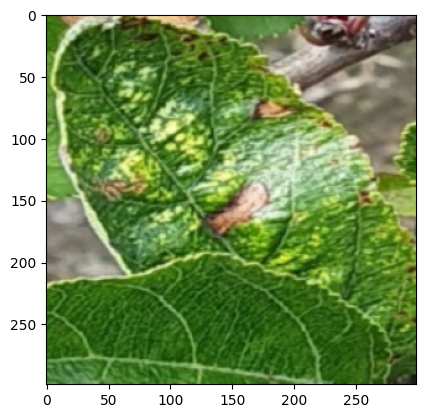

In [73]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model_tl.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

##  Plotting the accuracy, loss and the epoch curves

In [74]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']


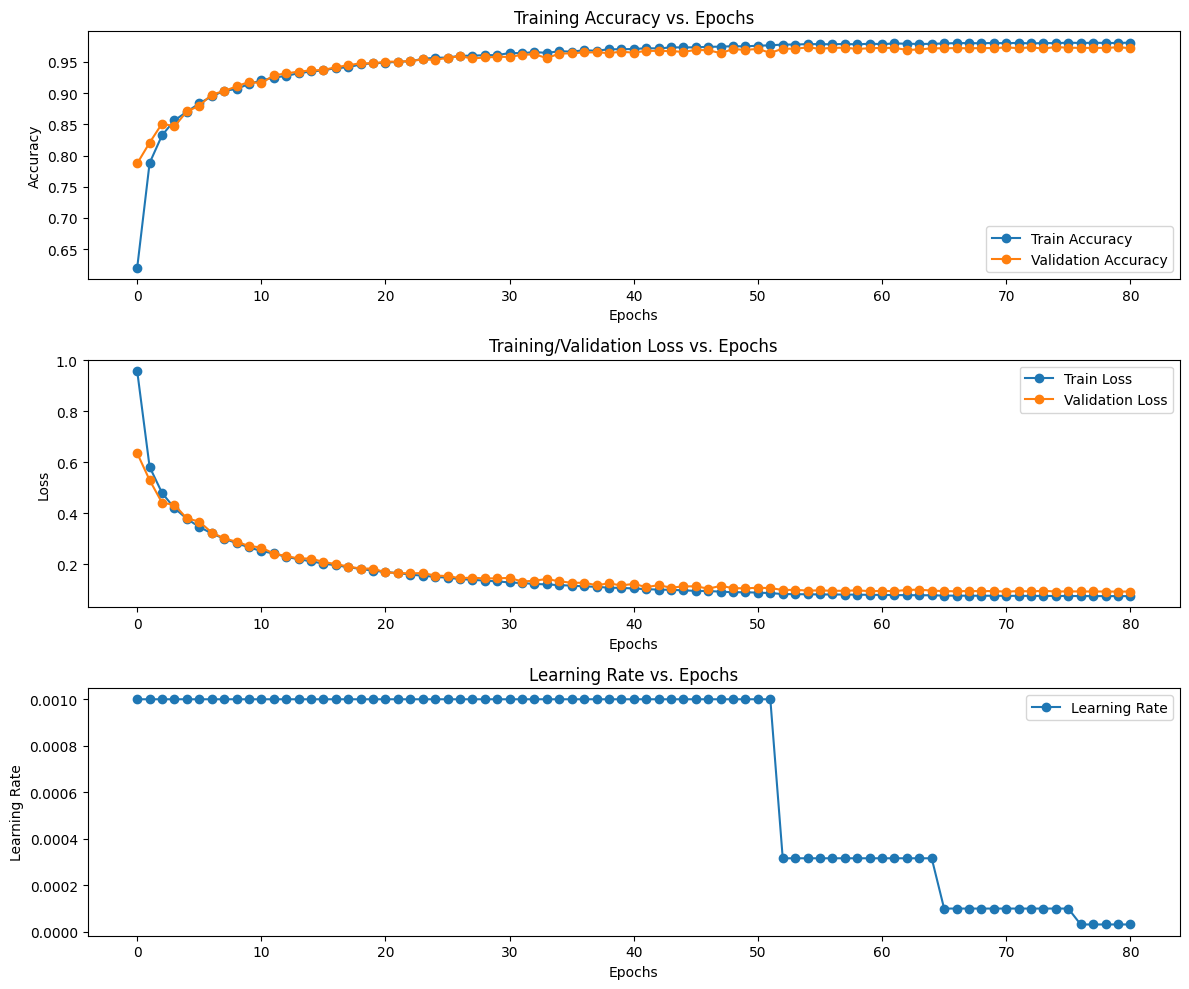

In [75]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Learning Rate')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()


Confusion Matrix

2/2 [==============================] - 0s 81ms/step


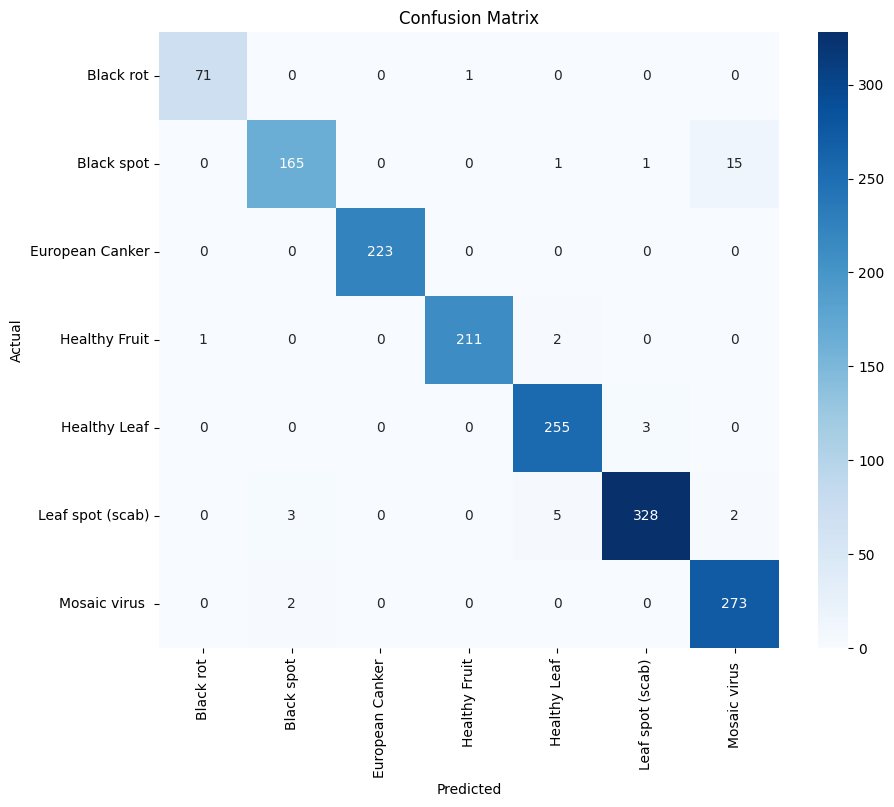

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model_tl.predict(images)  # Get model predictions
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())  # Get predicted classes

# Confusion Matrix with class names
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [77]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names, zero_division=1)
print("Classification Report:\n", report)


Classification Report:
                   precision    recall  f1-score   support

       Black rot       0.99      0.99      0.99        72
      Black spot       0.97      0.91      0.94       182
 European Canker       1.00      1.00      1.00       223
   Healthy Fruit       1.00      0.99      0.99       214
    Healthy Leaf       0.97      0.99      0.98       258
Leaf spot (scab)       0.99      0.97      0.98       338
   Mosaic virus        0.94      0.99      0.97       275

        accuracy                           0.98      1562
       macro avg       0.98      0.98      0.98      1562
    weighted avg       0.98      0.98      0.98      1562



ROC AUC

2/2 [==============================] - 0s 77ms/step


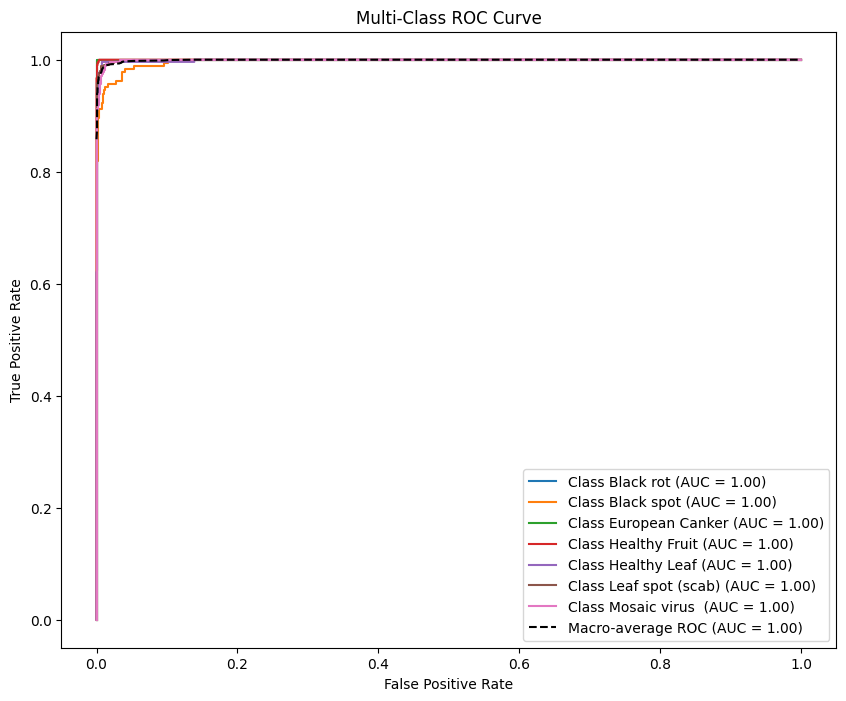

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model_tl.predict(images)  # Get model predictions (probabilities)
    y_pred_probs.extend(predictions)  # Collect predicted probabilities

# Convert to NumPy arrays
y_true = np.array(y_true)  # Ensure true labels are arrays
y_pred_probs = np.array(y_pred_probs)  # Ensure predicted probabilities are arrays

# Binarize the true labels to get a one-hot encoded representation
y_true_bin = label_binarize(y_true, classes=list(range(20)))

# Initialize ROC and AUC data
fpr = dict()  # False positive rates
tpr = dict()  # True positive rates
roc_auc = dict()  # AUC for each class

# Compute ROC and AUC for each class
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])  # ROC data for each class
    roc_auc[i] = auc(fpr[i], tpr[i])  # AUC for each class

# Compute macro-average AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))
mean_tpr = np.zeros_like(all_fpr)

# Compute mean true positive rates
for i in range(classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= classes  # Normalize by the number of classes
macro_auc = auc(all_fpr, mean_tpr)  # Macro-average AUC

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')  # Label with class names and AUC

# Plot the macro-average ROC curve
plt.plot(all_fpr, mean_tpr, color='k', linestyle='--', label=f'Macro-average ROC (AUC = {macro_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()


Classification Report on External Dataset

In [79]:
# Get true and predicted labels
y_true_external = []
y_pred_external = []

for images, labels in external_test:
    y_true_external.extend(labels.numpy())  # Collect true labels
    predictions = model_tl.predict(images)  # Get model predictions
    y_pred_external.extend(tf.argmax(predictions, axis=1).numpy())  # Get predicted classes




report = classification_report(y_true_external, y_pred_external, target_names=class_names, zero_division=1)
print("Classification Report:\n", report)

2/2 [==============================] - 0s 77ms/step
Classification Report:
                   precision    recall  f1-score   support

       Black rot       0.82      0.21      0.34        42
      Black spot       0.32      0.62      0.42       120
 European Canker       0.89      1.00      0.94        72
   Healthy Fruit       0.64      0.98      0.78        90
    Healthy Leaf       0.67      0.03      0.06       126
Leaf spot (scab)       0.40      0.15      0.22        54
   Mosaic virus        0.74      0.81      0.77       222

        accuracy                           0.60       726
       macro avg       0.64      0.54      0.50       726
    weighted avg       0.64      0.60      0.54       726



### Write a function for inference for the Transfer Learning model

In [80]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images from the test model**

In [81]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model_tl, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

Now run inference on few sample images from the external model

In [82]:
plt.figure(figsize=(15, 15))
for images, labels in external_test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model_tl, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

Save the Model

In [84]:
import os

# Define the base path for saving the model
base_path = "/content/drive/MyDrive/Classroom/Dissertation/models/"

# Ensure the base path exists
os.makedirs(base_path, exist_ok=True)

# Find the current highest model version (ensuring only numeric entries are considered)
numeric_dirs = [int(i) for i in os.listdir(base_path) if i.isdigit()]

# Determine the next model version
model_version = max(numeric_dirs + [0]) + 1

# Create the full path for saving the model, including the .h5 extension
model_path = os.path.join(base_path, f"{model_version}.h5")

# Save the model in HDF5 format
model_tl.save(model_path)
